# Lab exercise: Real NVP

In [51]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import itertools
import random
import math
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

%matplotlib inline

In [52]:
# samples1-2 shape must be (n samples, 2)
def plot_samples(samples1, samples2=None):
    fig, ax = plt.subplots()

    ax.scatter(samples1[:,0], samples1[:,1], marker="x", color="blue")
    if samples2 is not None:
        ax.scatter(samples2[:,0], samples2[:,1], marker="x", color="red")

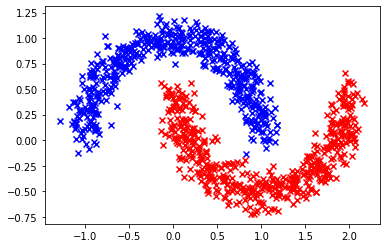

In [53]:
import sklearn.datasets

target_samples, target_classes = sklearn.datasets.make_moons(1000, noise=0.1)
target_samples = torch.from_numpy(target_samples).float()

plot_samples(target_samples[target_classes ==0], target_samples[target_classes == 1])

In [54]:
class RealNVPLayer(nn.Module):
    def __init__(self, size, reverse=False):
        super().__init__()
        
        self.mask = torch.zeros(size, requires_grad=False)
        # index that indicate the half of the vector
        # we use it to construct masks that indicate
        # which part of the vector we will modify
        mid = int(size / 2)
        if reverse:
            # in the reverse layer, we will keep the lower part 
            self.mask[mid:] = 1.
        else:
            # otherwise, we will keep the first half (upper part)
            self.mask[:mid] = 1.
        
        # the two operations: scaling and transposing
        # which are MLP
        self.scale = nn.Sequential(
            nn.Linear(size, 10),
            nn.Tanh(),
            nn.Linear(10, size),
        )
        self.transpose = nn.Sequential(
            nn.Linear(size, 10),
            nn.Tanh(),
            nn.Linear(10, size),
        )
        
    # project from the latent space to the observed space,
    # i.e. x = g(z)
    def forward(self, z):
        # mask that filters out 
        # the first half of the latent vector
        n_mask = 1. - self.mask
        # latent vector with values in only its first half
        z_masked = z * self.mask
        
        # BEGIN TODO
        """
        The transformation g(z) = x :
        x[1:m] = z[1:m]
        x[m+1:n] = z[m+1:n] * exp(scale(z[1:m])) + transpose(z[1:m])
        """

        x = z_masked + (z * n_mask) * torch.exp(self.scale(z_masked)) + n_mask * self.transpose(z_masked)
        # END TODO
        return x
    
    # project from the observed space to the latent space,
    # this function also return the log det jacobian of this inv function
    def inv(self, x):
        """
        The transformation f(x) = z :
        z[1:m] = x[1:m]
        z[m+1:n] = ( x[m+1:n] - transpose(x[1:m]) ) * exp(-scale(x[1:m]))
        """
        n_mask = 1. - self.mask
        x_masked = x * self.mask
        
        # BEGIN TODO        
        z = x_masked + (x*n_mask)* torch.exp(-self.scale(x_masked)) \
            - n_mask * self.transpose(x_masked) * torch.exp(-self.scale(x_masked))
        
        log_det_jacobian = (-n_mask* self.scale(x_masked)).sum(1)
        # END TODO
        
        return z, log_det_jacobian

In [55]:
# Test!
layer = RealNVPLayer(2, reverse=False)

with torch.no_grad():
    x = torch.rand(1, 2)
    z, _ = layer.inv(x)
    xx = layer(z)

    print("In the 3 vectors below, the first element must be equal")
    print("This two vectors should be equal:")
    print(x)
    print(xx)
    print("This vector should be different to the two above")
    print(z)
print()

layer = RealNVPLayer(2, reverse=True)

with torch.no_grad():
    x = torch.rand(1, 2)
    z, _ = layer.inv(x)
    xx = layer(z)

    print("In the 3 vectors below, the second element must be equal")
    print("This two vectors should be equal:")
    print(x)
    print(xx)
    print("This vector should be different to the two above")
    print(z)

In the 3 vectors below, the first element must be equal
This two vectors should be equal:
tensor([[0.9696, 0.5465]])
tensor([[0.9696, 0.5465]])
This vector should be different to the two above
tensor([[ 0.9696, -0.0466]])

In the 3 vectors below, the second element must be equal
This two vectors should be equal:
tensor([[0.3766, 0.2965]])
tensor([[0.3766, 0.2965]])
This vector should be different to the two above
tensor([[1.6332, 0.2965]])


In [56]:
class RealNVP(nn.Module):
    def __init__(self, size, n_layers):
        super().__init__()
        
        # The prior of our latent variables is a bivariate Gaussian
        self.prior = torch.distributions.normal.Normal(torch.zeros(2), torch.ones(2))
        
        # We will have a combination of coupling layers
        # where each layer modifies the opposite partition or half
        # of the input vector
        # so the composition modifies every dimension
        self.layers = nn.ModuleList(
                            RealNVPLayer(size, i % 2 == 0)
                            for i in range(n_layers)
        )
    
    def forward(self, z):
        """
        Function that computes the transformation x = g(z)to get 
        the obseved sampled from the latent variable. Because we 
        have now a composition of layers, we will iteratively apply
        the transformations over a variable called x.
        """
        x = z
        for i in range(len(self.layers)):
            x = self.layers[i](x)
        return x
    
    def inv(self, x):
        """
        Function that computes the transformation z = f(x), f = g^-1 ,
        to get the latent variable. Because we have now a composition 
        of layers, we will iteratively apply the inverse transformations 
        over one variable called z.
        """
        # accumulate the log(de|J(f(x))|)
        log_det_jacobian = 0.
        z = x
        
        # we have to walk through the layers in reverse order
        for i in reversed(range(len(self.layers))):
            # compute the inverse of the transformation
            z, j = self.layers[i].inv(z)
            # remember here, we just have to sum all log det jacobians!
            log_det_jacobian = log_det_jacobian + j
        return z, log_det_jacobian

    
    def sample(self, n_samples):
        """
        Function that samples some latent variables from the prior 
        (bivariate Gaussian), and then with those generates data 
        that belong to the observations space.
        """
        z = self.prior.sample((n_samples,))
        x = self(z)
        return x

    def log_prior(self, z):
        """
        Function that computes the log likelihood of the data:
        log(p(x)) = log(p(z)) + log(de|J(f(x))|)
        """
        x, det = self.inv(z)
        ret = self.prior.log_prob(x).sum(1) + det
        
        return ret

--- Trained in 111.7688238620758 seconds ---


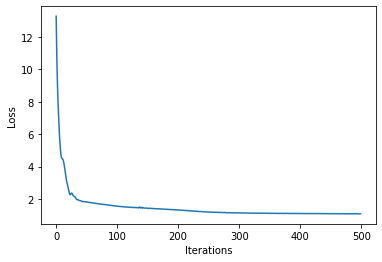

In [57]:
trained_distrib = RealNVP(2, 50)
optimizer = torch.optim.Adam(trained_distrib.parameters(), lr=1e-3)

batch_size = 1000
losses = list()
for _ in range(500):
    for i in range(0, target_samples.shape[0], batch_size):
        batch = target_samples[i:i+batch_size]
        optimizer.zero_grad()

        loss = -trained_distrib.log_prior(batch).mean()
        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(trained_distrib.parameters(), 5)
        optimizer.step()

print("--- Trained in %s seconds ---" % (time.time() - start_time))    
   
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.plot(np.arange(len(losses)), losses)


We can see that the loss stabilizes in less that 50 iterations, so we could have trained for less than 500 iterations as we set earlier

--- Trained in 44.449469804763794 seconds ---


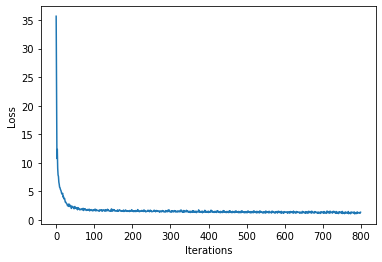

In [58]:
trained_distrib = RealNVP(2, 50)
optimizer = torch.optim.Adam(trained_distrib.parameters(), lr=1e-3)

batch_size = 64
losses = list()

start_time = time.time()
for _ in range(50):
    for i in range(0, target_samples.shape[0], batch_size):
        batch = target_samples[i:i+batch_size]
        optimizer.zero_grad()

        loss = -trained_distrib.log_prior(batch).mean()
        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(trained_distrib.parameters(), 5)
        optimizer.step()
        
print("--- Trained in %s seconds ---" % (time.time() - start_time))    

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.plot(np.arange(len(losses)), losses)


We can see that if we change the batch size by decreasing it, the loss curve shows some irregularities, but it still approximates to the minimum in less than 100 iterations.

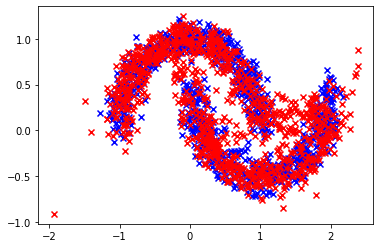

In [59]:
# sample from the model
with torch.no_grad():
    samples = trained_distrib.sample(1000)
    plot_samples(target_samples, samples)

We can see that our generated data (points shown in red) follow a distrbution very similar to the original data, with some outliers (for example the point in (-2,-1) ). It also generated points in the gaps between the half moons, like if it learned a continuous distribution function.

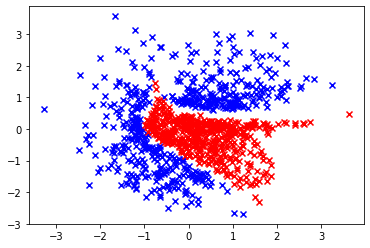

In [60]:
# print the latent space corresponding to each half moon in a different color
with torch.no_grad():
    source_sample1, _ = trained_distrib.inv(target_samples[target_classes == 0])
    source_sample2, _ = trained_distrib.inv(target_samples[target_classes == 1])
    plot_samples(source_sample1, source_sample2)

This plot shows a high density in the distribution of the latent variables in the area [-2:2,-2:2]. The latent variables of each class occupy a well-defined density area, with barely two latent variables of the class in red mixing in between the latent variables of the other class; they are in approx (-1,1).